# 🤖 Welcome to Our Multi-Agent Reinforcement Learning Research Project 🚀

Hi there! 👋 Welcome to our research project on **Multi-Agent Reinforcement Learning for Robot Navigation**. In this research, we focus on Single-Agent Q-learning applied to different environments and  multi agents communications techniques. By the end of this , we'll analyze the results and explore how our agent navigates through the environments.

# Overview of Reinforcement learning

The idea behind Reinforcement Learning is that an agent (an AI) will learn from the environment by interacting with it (through trial and error) and receiving rewards (negative or positive) as feedback for performing actions.

Learning from interactions with the environment comes from our natural experiences

 ### Formal Defination

 Reinforcement learning is a framework for solving control tasks (also called decision problems) by building agents that learn from the environment by interacting with it through trial and error and receiving rewards (positive or negative) as unique feedback.

## Q-learning Overview

### Terms and terminologies in reinforcement learning

1. **Agent**: The AI or  decision-maker that interacts with the environment to perform actions.

2. **Environment**: The external system that the agent interacts with and receives feedback from.

3. **State (s)**: A representation of the environment at a particular time.

4. **Action (A)**: A choice made by the agent, leading to a new state or outcome.

5. **Policy (π)**: A strategy or mapping from states to actions that the agent uses to determine its behavior.

6. **Reward (R)**: A scalar feedback signal received from the environment after performing an action in a state.

7. **Value Function (V)**: Measures the long-term expected reward starting from a state. 𝑉(𝑠)

8. **Action-Value Function (Q-Value)**: Measures the long-term expected reward for taking an action 𝑎 in a state 𝑠, denoted as 𝑄(𝑠,𝑎).

9. **Exploration vs. Exploitation**

  Exploration: Trying new actions to discover better rewards.

  Exploitation: Using known information to maximize reward.

10. **Discount Factor (𝛾)**: A parameter (0 ≤ 𝛾 ≤ 1) that determines the importance of future rewards. Lower 𝛾 values prioritize immediate rewards.

11. **Learning Rate (𝛼)**: A parameter (0 < 𝛼 ≤ 1) that controls how much the agent updates its value estimates during learning.

12. **Episode**: A sequence of states, actions, and rewards from the start to the end of a task.

13. **Transition Probability (𝑃(𝑠′∣𝑠,𝑎)P(s ′∣s,a))**: The probability of moving to a state 𝑠′ given current state 𝑠 and action 𝑎.

14. **Terminal State**: A state where the episode ends.

Q-Learning is an off-policy value-based method that uses a TD approach to train its action-value function

📌 **Off-Policy** : Q-Learning's ability to learn the optimal action-value function 𝑄∗(𝑠,𝑎)Q ∗ (s,a) for a target policy (greedy policy) while following a different behavior policy (e.g., epsilon-greedy).




📌 **TD Approach**: In Q-Learning, the Temporal Difference (TD) approach updates the Q-value based on the difference between the current estimate and the observed reward plus the discounted estimate of the next state's maximum Q-value.

📌 **Value-Based Method**: Q-Learning focuses on learning the action-value function 𝑄(𝑠,𝑎) directly, which represents the expected long-term reward for taking an action 𝑎 in a state 𝑠, and derives the policy from these values.

# Implementation of Q-learning on single agent

FrozenLake environment consists of a 4 by 4 grid representing a surface. The agent always starts from the state 0, [0,0] in the grid, and his goal is to reach the state 16, [4,4] in the grid. On his way, he could find some frozen surfaces or fall in a hole. If he falls, the episode is ended. When the agent reaches the goal, the reward is equal to one. Otherwise, it is equal to 0.

Read More on OpenAI Gym Documentation 👉 https://gymnasium.farama.org/environments/toy_text/frozen_lake/

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [ ]:
# Importing neccessary packages
import numpy as np
import gym



#### **Action Space**

The action shape is (1,) in the range {0, 3} indicating which direction to move the player.

0: Move left

1: Move down

2: Move right

3: Move up

#### **Observation Space**

The observation is a value representing the player’s current position as current_row * ncols + current_col (where both the row and col start at 0).

For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15. The number of possible observations is dependent on the size of the map.

The observation is returned as an int().

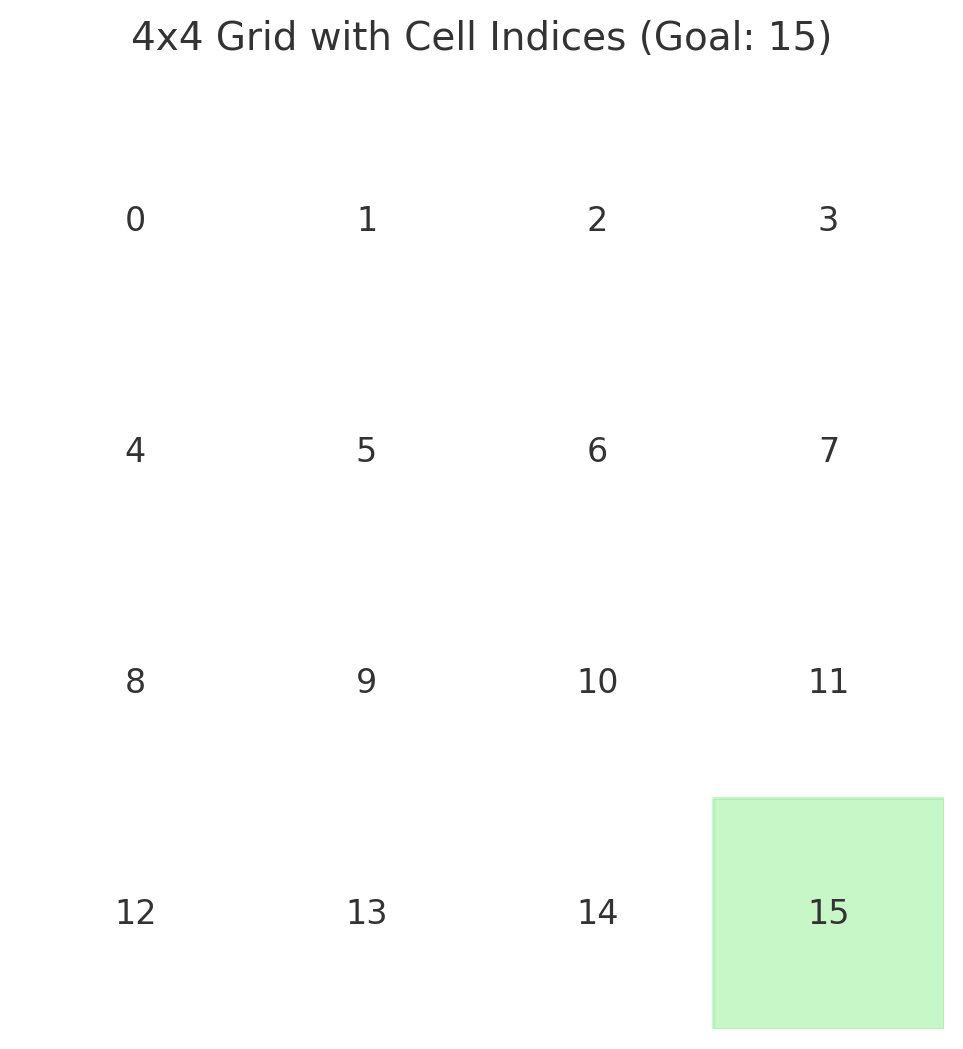

In [ ]:
# Initalize our enviroment
env = gym.make("FrozenLake-v1", new_step_api=True)
n_observations = env.observation_space.n
n_actions = env.action_space.n

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
Q_table = np.zeros((n_observations,n_actions))
print(Q_table)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import gymnasium as gym
from typing import Dict, List, Tuple
import math

# Custom Environment
class DroneSwarmEnv(gym.Env):
    def __init__(self, num_drones=3, world_size=(100, 100, 50)):
        super().__init__()
        self.num_drones = num_drones
        self.world_size = world_size

        # Define action and observation spaces
        # Actions: [dx, dy, dz, communication_bit] for each drone
        self.action_space = gym.spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(num_drones, 4),
            dtype=np.float32
        )

        # Observations: [x, y, z, vel_x, vel_y, vel_z, others_relative_pos(3*num_drones)]
        obs_dim = 6 + 3 * (num_drones - 1)
        self.observation_space = gym.spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(num_drones, obs_dim),
            dtype=np.float32
        )

        self.reset()

    def reset(self):
        # Initialize drone positions randomly
        self.drone_positions = np.random.uniform(
            low=[0, 0, 0],
            high=self.world_size,
            size=(self.num_drones, 3)
        )
        self.drone_velocities = np.zeros((self.num_drones, 3))

        return self._get_observation(), {}

    def _get_observation(self) -> np.ndarray:
        obs = []
        for i in range(self.num_drones):
            # Get current drone state
            drone_state = np.concatenate([
                self.drone_positions[i],
                self.drone_velocities[i]
            ])

            # Get relative positions of other drones
            relative_positions = []
            for j in range(self.num_drones):
                if i != j:
                    relative_pos = self.drone_positions[j] - self.drone_positions[i]
                    relative_positions.extend(relative_pos)

            # Combine all observations
            drone_obs = np.concatenate([drone_state, np.array(relative_positions)])
            obs.append(drone_obs)

        return np.array(obs)

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        # Update drone positions based on actions
        for i in range(self.num_drones):
            # Update velocity (actions[0:3] are dx, dy, dz)
            self.drone_velocities[i] += action[i, :3] * 0.1

            # Apply velocity limits
            self.drone_velocities[i] = np.clip(self.drone_velocities[i], -1.0, 1.0)

            # Update position
            self.drone_positions[i] += self.drone_velocities[i]

            # Apply position bounds
            self.drone_positions[i] = np.clip(
                self.drone_positions[i],
                [0, 0, 0],
                self.world_size
            )

        # Calculate reward
        reward = self._calculate_reward(action)

        # Check termination conditions
        done = self._check_collision() or self._check_goal_reached()

        return self._get_observation(), reward, done, False, {}

    def _calculate_reward(self, action: np.ndarray) -> float:
        reward = 0.0

        # Penalty for collisions
        if self._check_collision():
            reward -= 100.0
            return reward

        # Reward for maintaining formation
        formation_error = self._calculate_formation_error()
        reward -= 0.5 * formation_error

        # Penalty for communication
        communication_penalty = np.sum(action[:, 3]) * 0.1
        reward -= communication_penalty

        # Reward for progress toward goal
        goal_progress = self._calculate_goal_progress()
        reward += 5.0 * goal_progress

        return reward

    def _check_collision(self) -> bool:
        min_distance = 2.0  # Minimum safe distance between drones

        for i in range(self.num_drones):
            for j in range(i + 1, self.num_drones):
                distance = np.linalg.norm(
                    self.drone_positions[i] - self.drone_positions[j]
                )
                if distance < min_distance:
                    return True
        return False

    def _calculate_formation_error(self) -> float:
        # Implement desired formation metrics
        # Example: maintaining equal distances between drones
        desired_distance = 5.0
        error = 0.0

        for i in range(self.num_drones):
            for j in range(i + 1, self.num_drones):
                distance = np.linalg.norm(
                    self.drone_positions[i] - self.drone_positions[j]
                )
                error += (distance - desired_distance) ** 2

        return error / (self.num_drones * (self.num_drones - 1) / 2)

    def _check_goal_reached(self) -> bool:
        # Implement goal condition
        return False

    def _calculate_goal_progress(self) -> float:
        # Implement progress metric
        return 0.0

# PPO Network Architecture
class ActorCritic(nn.Module):
    def __init__(self, num_drones: int, obs_dim: int, action_dim: int):
        super().__init__()

        self.actor = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim * 2)  # Mean and log_std for each action
        )

        self.critic = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        action_params = self.actor(state)
        value = self.critic(state)

        # Split into mean and log_std
        mean, log_std = torch.chunk(action_params, 2, dim=-1)
        log_std = torch.clamp(log_std, -20, 2)

        return mean, log_std, value

# PPO Agent
class PPOAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float = 3e-4,
        gamma: float = 0.99,
        clip_ratio: float = 0.2,
        target_kl: float = 0.01
    ):
        self.env = env
        num_drones = env.num_drones
        obs_dim = env.observation_space.shape[1]
        action_dim = env.action_space.shape[1]

        self.actor_critic = ActorCritic(num_drones, obs_dim, action_dim)
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=learning_rate)

        self.gamma = gamma
        self.clip_ratio = clip_ratio
        self.target_kl = target_kl

    def get_action(self, state: np.ndarray) -> Tuple[np.ndarray, dict]:
        state_tensor = torch.FloatTensor(state)
        with torch.no_grad():
            mean, log_std, _ = self.actor_critic(state_tensor)
            std = log_std.exp()

            # Sample action from normal distribution
            normal = Normal(mean, std)
            action = normal.sample()
            log_prob = normal.log_prob(action).sum(dim=-1)

        return action.numpy(), {'log_prob': log_prob.numpy()}

    def learn(
        self,
        states: np.ndarray,
        actions: np.ndarray,
        advantages: np.ndarray,
        log_probs: np.ndarray,
        values: np.ndarray
    ) -> dict:
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        advantages = torch.FloatTensor(advantages)
        old_log_probs = torch.FloatTensor(log_probs)

        # PPO update
        for _ in range(80):  # Number of optimization epochs
            mean, log_std, values_pred = self.actor_critic(states)
            std = log_std.exp()

            normal = Normal(mean, std)
            new_log_probs = normal.log_prob(actions).sum(dim=-1)

            ratio = torch.exp(new_log_probs - old_log_probs)
            clip_adv = torch.clamp(ratio, 1-self.clip_ratio, 1+self.clip_ratio) * advantages
            loss = -torch.min(ratio * advantages, clip_adv).mean()

            # Value loss
            value_loss = ((values_pred - values) ** 2).mean()

            # Total loss
            total_loss = loss + 0.5 * value_loss

            # Optimize
            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()

            # Calculate KL divergence
            kl = (old_log_probs - new_log_probs).mean()
            if kl > self.target_kl:
                break

        return {
            'actor_loss': loss.item(),
            'value_loss': value_loss.item(),
            'kl': kl.item()
        }

# Training loop
def train():
    env = DroneSwarmEnv(num_drones=3)
    agent = PPOAgent(env)

    num_episodes = 1000

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action, info = agent.get_action(state)
            next_state, reward, done, _, _ = env.step(action)

            # Store transition
            # (Implement your replay buffer here)

            state = next_state
            episode_reward += reward

        # Update policy
        # (Implement your update logic here)

        if episode % 10 == 0:
            print(f"Episode {episode}, Reward: {episode_reward}")

if __name__ == "__main__":
    train()

## $$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma \max_a Q(S_{t+1}, a) - Q(S_t, A_t) \right]$$


$ →$ New Q-value estimation: $Q(S_t, A_t) \leftarrow$

$ →$  Q-value estimation: $Q(S_t, A_t)$

$ →$  Learning Rate: $\alpha$

$ →$  Immediate Reward: $ R_{t+1} $

$ →$  Discounted Estimate optimal Q-value of next state: $\gamma \max_a Q(S_{t+1}, a)$

$ →$ TD Target: Spans over the bracketed term: $\left[R_{t+1} + \gamma \max_a Q(S_{t+1}, a)\right]$

$ →$  TD Error: The difference: $\left[R_{t+1} + \gamma \max_a Q(S_{t+1}, a) - Q(S_t, A_t)\right]$


In [ ]:
# Defining our paramters

n_episodes = 1000000
max_iter_episode = 100
exploration_proba = 1
exploration_decreasing_decay = 0.001
min_exploration_proba = 0.01
gamma = 0.99
lr = 0.1

In [ ]:
# Store total reward
total_rewards_episode = list()
rewards_per_episode = []

In [ ]:
# Iteration through each episode
for e in range(n_episodes):
    current_state = env.reset()
    done = False
    total_episode_reward = 0

    for i in range(max_iter_episode):

        if np.random.uniform(0, 1) < exploration_proba:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[current_state, :])


        # next_state, reward, done = env.step(action)
        next_state, reward, terminated, truncated, info = env.step(action)


        Q_table[current_state, action] = (1 - lr) * Q_table[current_state, action] + \
                                         lr * (reward + gamma * np.max(Q_table[next_state, :]))


        total_episode_reward += reward


        if terminated or truncated:
            break

        current_state = next_state


    exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay * e))

    rewards_per_episode.append(total_episode_reward)


In [ ]:
print("Mean reward per thousand episodes")
for i in range(10):
    print(f"{(i+1)*1000}: mean espiode reward: ",\
           np.mean(rewards_per_episode[1000*i:1000*(i+1)]))

Mean reward per thousand episodes
1000: mean espiode reward:  nan
2000: mean espiode reward:  nan
3000: mean espiode reward:  nan
4000: mean espiode reward:  nan
5000: mean espiode reward:  nan
6000: mean espiode reward:  nan
7000: mean espiode reward:  nan
8000: mean espiode reward:  nan
9000: mean espiode reward:  nan
10000: mean espiode reward:  nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
